# Use DUM-TV in the most verbosed way

### load image

In [16]:
from pathlib import Path

p = Path("/mnt/d/onedrive/OneDrive_cityu/OneDrive - City University of Hong Kong - Student/workspace/Dataset/DenoiseToy/data/test/clean/29026.jpg")
assert p.exists(),p

PSNR(dB): the higher, the cleaner
 30dB+ acceptable, 40dB+ good
clean: min/max 0.0 1.0


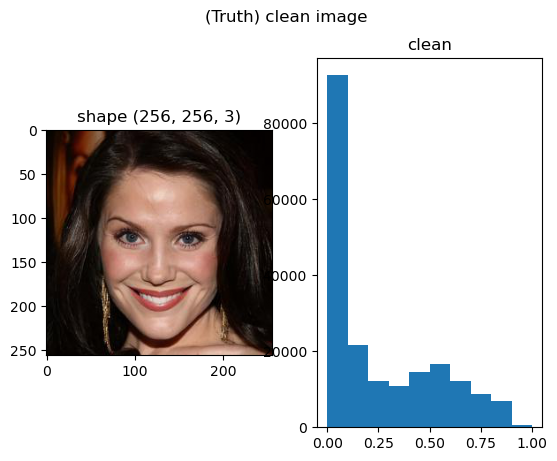

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


noisy: min/max -0.44438631442017595 1.2082386565829686


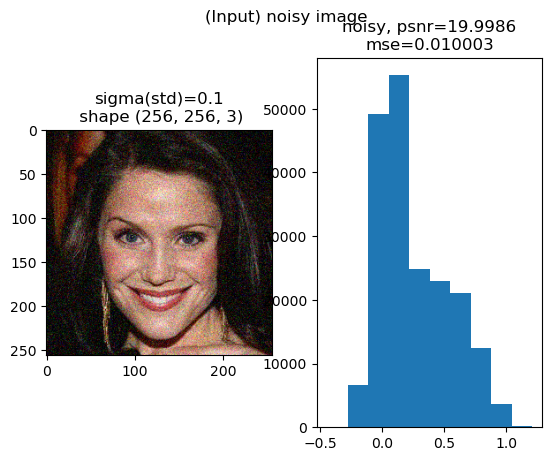

In [17]:


from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
import torch

print("PSNR(dB): the higher, the cleaner\n 30dB+ acceptable, 40dB+ good")

def load(p,show=True):
    img = Image.open(p)
    imga = np.array(img)
    if show:
        plt.imshow(img)
        plt.show()
    return imga

clean = load(p,show=False)/255
print("clean: min/max", clean.min(),clean.max())
fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.set_title(f"shape {clean.shape}")
ax.imshow(clean)
ax = axes[1]
ax.set_title("clean")
ax.hist(clean.flatten())
fig.suptitle('(Truth) clean image')
plt.show()

sigma = 0.1
noisy = clean + np.random.randn(*clean.shape)*sigma
psnr = peak_signal_noise_ratio(clean,noisy)
mse = torch.nn.functional.mse_loss(torch.tensor(noisy),torch.tensor(clean))
print("noisy: min/max", noisy.min(), noisy.max())
fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.imshow(noisy)
ax.set_title(f"sigma(std)={sigma}\n shape {noisy.shape}")
ax = axes[1]
ax.set_title(f"noisy, psnr={psnr:.4f}\nmse={mse:.6f}")
ax.hist(noisy.flatten())
fig.suptitle('(Input) noisy image')
plt.show()

In [18]:
import torch
import pytorch_lightning as pl
device = torch.device("cuda:0")

$\begin{align}
  % Step1
  \text{Step1 }&
  \left.\begin{aligned}
    \text{Forward }y=x+n,\\ 
    n\text{:Gaussian noise.}
  \end{aligned}\right\}\Rightarrow\left\{
  \begin{aligned}
    &\text{Energy minimization: }\\
    &\mathop{\arg\min}_x E(x;y)=\frac{1}{2}\|y-x\|_2^2 + \beta\|D x\|_1
  \end{aligned}\right.\\
\end{align}$
$\begin{align}
  %Step2
  \text{Step2 }
  & L(x,z;y):= \frac{1}{2}\|y-x\|_2^2 + \beta\|z\|_1 +\frac{\rho}{2}\|Dx-z+\frac{\lambda}{\rho}\|_2^2\\
  &\text{(ADMM)}\left\{\begin{aligned}
    x^{l+1}:=\mathop{\arg\min}_x L(x,z^{l},\lambda^{l};y)\\
    z^{l+1}:=\mathop{\arg\min}_z L(x^{l+1},z,\lambda^{l};y)\\
    \lambda^{l+1}:= \lambda^{l} + Dx^{l+1}-z^{l+1}
  \end{aligned}\right.
\end{align}$

$\begin{align}
    % Step3
    \text{Step3 }
    & \text{Learnable parameters: }\theta:=(\beta,\rho,D)\\
    & \text{(ADMM)}\left\{\begin{aligned}
        x^{l+1}&:=(\rho {D}^TD+I)^{-1}(y+\rho {D}^T(z^l-\frac{\lambda^l}{\rho}))\\
        z^{l+1}&:=\mathcal{S}(Dx^{l+1} + \frac{\lambda^l}{\rho};\frac{\beta}{\rho})\\
        \lambda^{l+1}&:= \lambda^{l} + \rho( Dx^{l+1}-z^{l+1})
      \end{aligned}\right.\\
    & \text{Soft-thresholding: }\mathcal{S}(s;c):=\mathop{\text{sgn}}(x)\max(|x|-c,0)\\
\end{align}$

$\begin{align}
    % Step4
    \text{Step4 }
    & \begin{aligned}&\text{Data: }(\text{clean: }x,\text{noisy: }y)\\
    &\text{Input: }x^0\\
    & \text{Output: }x^L (\text{e.g. }L=6)\\
    & \text{Training loss} := \|x^L-x\|_2^2\end{aligned}
\end{align}$

In this implementation, we denote:
- the input $y$ as `f` of shape `(B,C,H,W)`,
- the reconstruction $x$ as `u`,
- Learnable parameters as 
  - `beta`=$\beta$, 
  - `gamma` = $\frac{\beta}{\rho}$
  - `KerK` = $D:=(\nabla_x, \nabla_y)$, of shape `(kO=2,1,2*kR+1,2*kR+1)`.
- State of layer `l=0,1,...L-1`:
  - `u`=$x^{l+1}$
  - `p`=$z^{l+1}$
  - `mu`=$\frac{\lambda^{l+1}}{\rho}$

In [19]:

from dum_tv.apps.model.tv_m import TVNet

def loop(f, # input
         u,p,mu, # state
         *,kerK,gamma,rho,# param
         N:int): #number of loop
    assert f.shape ==u.shape
    assert f.dtype ==u.dtype
    log = {
        "du_dt":[]
    }
    for i in range(N):
        u_old = u
        u,p,mu = TVNet._step(f,u,p,mu,kerK=kerK,gamma=gamma,rho=rho)
        du_dt = (torch.norm(u_old-u)/u.numel()).detach().cpu().clone().item()
        log["du_dt"].append(du_dt)
    return (u,p,mu),(log,)

def loop_init(f,*,kO):
    B,C,H,W = f.shape
    device= f.device
    u= torch.zeros((B,C,H,W))
    p= torch.zeros((B,C*kO,H,W))
    mu= torch.zeros((B,C*kO,H,W))
    return u.to(device),p.to(device),mu.to(device)

In [20]:
f = torch.tensor(noisy).clone().permute(2,0,1).unsqueeze(0).float().to(device)

In [21]:

from dum_tv.apps.model.tv_m import Varia, init_varia


"""
kO:int      #     number of kernels; kerK.shape[0]
kR:int      #     (2*kR+1)  size of kernel
C:int       #     channel of $f$, the input of DecNet
kerK:Tensor #     str;  See getKernel_dispatch.
beta:Tensor #     1,
rho:Tensor  #     1,"""
varia = Varia(2,1,3,"DxDy",0.075,0.045)
init_varia(varia,device)
varia_init = varia._initialized # dict

In [22]:

kO = varia.kO
n_iteration = 64
state = {
    "kerK":varia_init["kerK"],
    "gamma":varia_init["gamma"],
    "rho":varia_init["rho"],
}
(u,p,mu),(log,) = loop(f,*loop_init(f,kO=kO),**state,N = n_iteration)

uN = u


/tmp/ipykernel_4113/2802831450.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_rest = peak_signal_noise_ratio(clean,restore)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


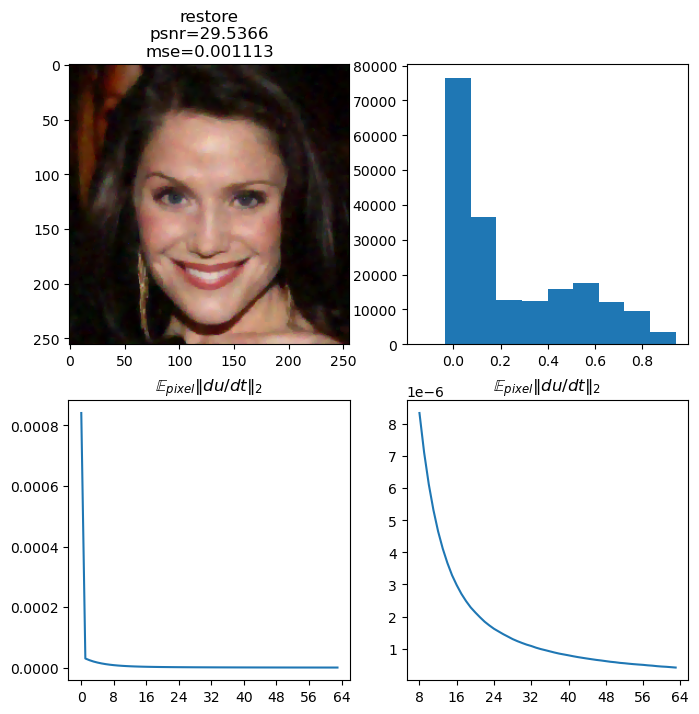

In [23]:
restore = uN.detach().cpu()[0].permute(1,2,0).numpy()
psnr_rest = peak_signal_noise_ratio(clean,restore)
mse_rest = torch.nn.functional.mse_loss(torch.tensor(restore),torch.tensor(clean))
fig,axes = plt.subplots(2,2,figsize=(8,8))
ax = axes[0][0]
ax.imshow(restore)
ax.set_title(f"restore\npsnr={psnr_rest:.4f}\nmse={mse_rest:6f}")
ax = axes[0][1]
ax.hist(restore.flatten())

ax = axes[1][0]
ax.set_title("$\mathbb{E}_{pixel}\|du/dt\|_2$")
du_dt_= log["du_dt"]
ax.plot(range(0,len(du_dt_)),du_dt_)
ax.set_xticks([*range(0,len(du_dt_),8),len(du_dt_)])
ax = axes[1][1]
ax.set_title("$\mathbb{E}_{pixel}\|du/dt\|_2$")
du_dt_= log["du_dt"][8:]
ax.plot(range(8,8+len(du_dt_)),du_dt_)
ax.set_xticks([*range(8,8+len(du_dt_),8),8+len(du_dt_)])
plt.show()

## Load pretrained


In [24]:
from pathlib import Path
import yaml
from pprint import pprint,pformat
proot = Path("/home/tjrym/workspace/DUM-TV/Results/main__denoise_training/lightning_logs/version_1")
with open(Path(proot,"config.yaml"), 'r') as file:
    config = yaml.safe_load(file)
pprint(config)

{'lr': 0.0002,
 'lr_scheduler_frequency': 2000,
 'max_epochs': 20,
 'n_iteration': 64,
 'patch_shape': [3, 256, 256],
 'varia_d': {'C': 3,
             'beta': 0.04,
             'kO': 4,
             'kR': 5,
             'kerK': 'DxDy',
             'rho': 0.8},
 'varia_d-name': 'Toy'}


In [25]:
import torch
from dum_tv.apps.model import main
varia = Varia(**config["varia_d"])
init_varia(varia,device)
tvnet = main.TVNet(config["patch_shape"],config["n_iteration"],None,varia.as_controled_init())




In [32]:

ckpt = torch.load(Path(proot,"checkpoints","best_train_loss_epoch-epoch=19.ckpt").as_posix(),map_location=device)
pprint(list(ckpt["state_dict"].keys())[:10])
pprint(list(ckpt["state_dict"].keys())[-10:])

state_dict = { ".".join(str(k).split(".")[1:]):v for k,v in ckpt["state_dict"].items()}



['tvnet.controled_init.0.gamma',
 'tvnet.controled_init.0.kerK',
 'tvnet.controled_init.0.rho',
 'tvnet.controled_init.1.gamma',
 'tvnet.controled_init.1.kerK',
 'tvnet.controled_init.1.rho',
 'tvnet.controled_init.2.gamma',
 'tvnet.controled_init.2.kerK',
 'tvnet.controled_init.2.rho',
 'tvnet.controled_init.3.gamma']
['tvnet.controled_init.60.rho',
 'tvnet.controled_init.61.gamma',
 'tvnet.controled_init.61.kerK',
 'tvnet.controled_init.61.rho',
 'tvnet.controled_init.62.gamma',
 'tvnet.controled_init.62.kerK',
 'tvnet.controled_init.62.rho',
 'tvnet.controled_init.63.gamma',
 'tvnet.controled_init.63.kerK',
 'tvnet.controled_init.63.rho']


In [33]:
tvnet.load_state_dict(state_dict)

<All keys matched successfully>

In [34]:
def predict(x0,*,tvnet,state_d=None):
    # u = tvnet.loop(f)
    # Input
    self = tvnet # type: TVNet
    f = x0
    u,p,mu = self.loop_init(x0,state_d)
    log = {"du_dt":[]}
    for i in range(self.n_steps):
        #TODO:TVNet.loop: Mixin control_model
        args = {k:self.controled_init[i][k]
            for k in self.controled_names
        }
        u_old = u
        u,p,mu = self.step(f, u, p, mu, 
                                kerK=args["kerK"],
                                gamma=args["gamma"], 
                                rho=args["rho"])
        
        du_dt = (torch.norm(u_old-u)/u.numel()).detach().cpu().clone().item()
        log["du_dt"].append(du_dt)
    return (u,p,mu),(log,)



In [35]:
f = torch.tensor(noisy).clone().permute(2,0,1).unsqueeze(0).float().to(device)
(u_pred,*_),(log,) = predict(f,tvnet=tvnet)

/tmp/ipykernel_4113/1624209183.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_rest = peak_signal_noise_ratio(clean,restore)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


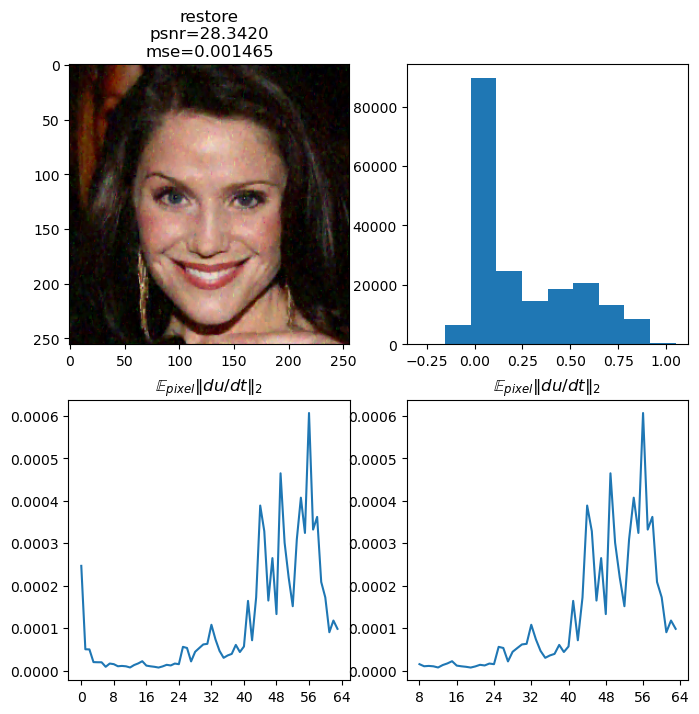

In [36]:
restore = u_pred.detach().cpu()[0].permute(1,2,0).numpy()
psnr_rest = peak_signal_noise_ratio(clean,restore)
mse_rest = torch.nn.functional.mse_loss(torch.tensor(restore),torch.tensor(clean))
fig,axes = plt.subplots(2,2,figsize=(8,8))
ax = axes[0][0]
ax.imshow(restore)
ax.set_title(f"restore\npsnr={psnr_rest:.4f}\nmse={mse_rest:6f}")
ax = axes[0][1]
ax.hist(restore.flatten())
ax = axes[1][0]
ax.set_title("$\mathbb{E}_{pixel}\|du/dt\|_2$")
du_dt_= log["du_dt"]
ax.plot(range(0,len(du_dt_)),du_dt_)
ax.set_xticks([*range(0,len(du_dt_),8),len(du_dt_)])
ax = axes[1][1]
ax.set_title("$\mathbb{E}_{pixel}\|du/dt\|_2$")
du_dt_= log["du_dt"][8:]
ax.plot(range(8,8+len(du_dt_)),du_dt_)
ax.set_xticks([*range(8,8+len(du_dt_),8),8+len(du_dt_)])
plt.show()